In [13]:
# Super Market Management System
from mysql.connector import connect, Error
from getpass import getpass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
try:
        conn = connect(
            host='localhost',
            user='root',
            password=getpass('Enter password'),
            database='kwikmart'
        );
        print("Welcome to kwik mart!!");
except Error as e:
        print(e)

Enter password········
Welcome to kwik mart!!


In [15]:
def getCategoriesRevenue(conn, start_date, end_date):
    query='''
    select c.category_name as category_name, SUM(b.quantity * b.net_price) as revenue from category c, item i, 
    (SELECT * from bill_items
    where bill_items.bill_id in (
    Select bill.bill_id from bill
    where bill.bill_date >= %s and bill.bill_date <= %s
    )
    ) b
    where c.category_id = i.category_id and i.item_id = b.item_id 
    group by c.category_id
    order by revenue desc
    ''';
    value_tuple=(start_date, end_date);
    df = pd.read_sql(query, conn, params=[start_date, end_date])
    plt.bar(df.category_name, df.revenue)
    plt.xticks(rotation=90)
    plt.show()



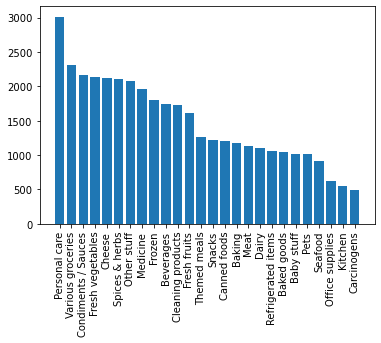

In [16]:
getCategoriesRevenue(conn, '2022-01-01', '2022-12-30')

In [17]:
def numOfstoresVsRevenue(conn):
    query1 = '''
    Select t1.state, t1.numOfStores, t2.revenue from
    (select count(*) as numOfStores, store.state
    from store
    group by store.state
    order by store.state) t1 join 
    (    select store.state, SUM(revenue) as revenue
    from store left outer join (
    select bill.store_id, Sum(bill_items.quantity * bill_items.net_price) as revenue
    from bill, bill_items
    where bill.bill_id = bill_items.bill_id
    group by bill.store_id) temp
    on store.store_id = temp.store_id
    group by store.state) t2
    where t2.state = t1.state
    order by t1.numOfStores
    ''';

    
    df = pd.read_sql(query1, conn);


     


    fig, ax = plt.subplots(figsize=(10,25))
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Revenue in $')
    ax.scatter(df.numOfStores, df.revenue)

    
    for i, txt in enumerate(df.state):
        ax.annotate(txt, (df.numOfStores[i], df.revenue[i]))
        




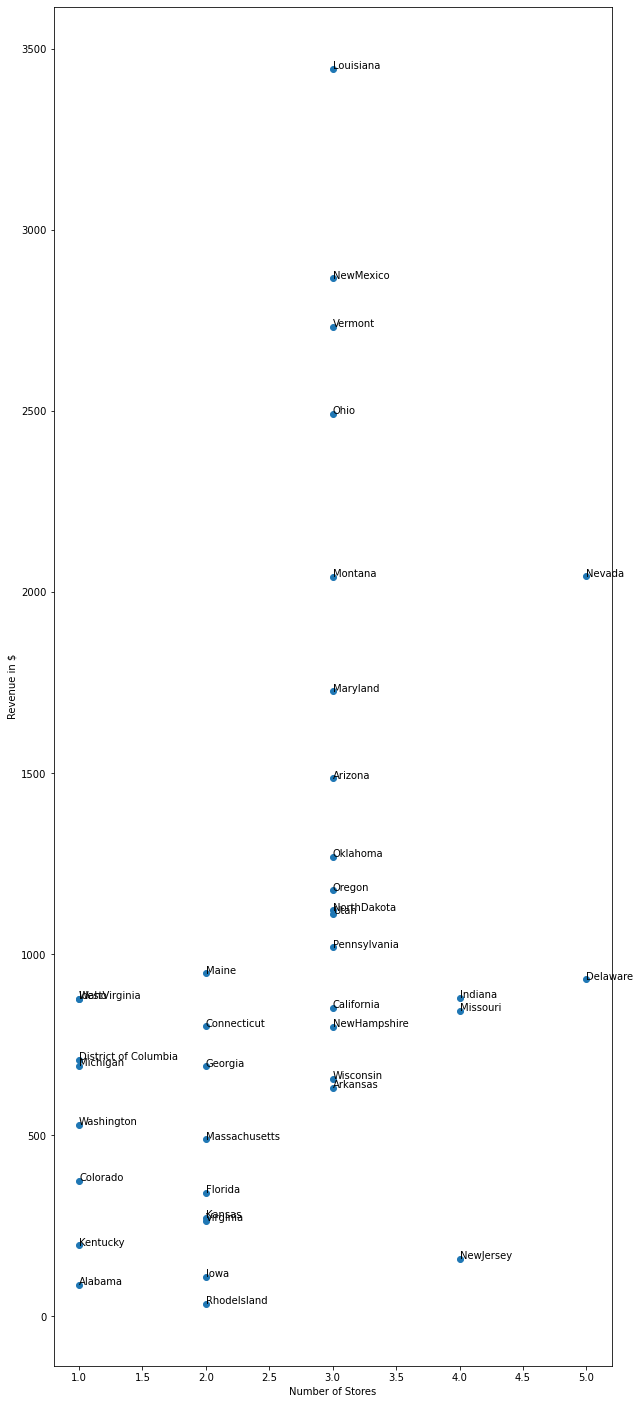

In [18]:
numOfstoresVsRevenue(conn)

In [19]:
def revenueInEachQuarter():
    query='''
    SELECT CEILING(MONTH(b.bill_date)/3) AS quarter, SUM(bi.net_price*bi.quantity) net_revenue
    FROM bill_items bi
    JOIN bill b ON b.bill_id = bi.bill_id
    GROUP BY 1
    ORDER BY quarter
    ''';
    
    df = pd.read_sql(query, conn);
    
    myexplode = [0, 0.1, 0, 0]

    plt.pie(df.net_revenue, labels = df.quarter, explode = myexplode)
    plt.show() 

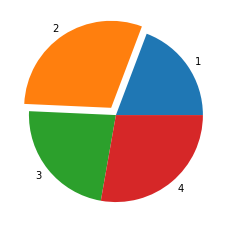

In [20]:
revenueInEachQuarter()

In [21]:
cursor = conn.cursor()

In [ ]:
# All the functions and stored procedures are tested below

In [ ]:
# We have 3 stored procedures
# add item to cart, get bill, check if nearby stores have the required item
# We have 4 functions
# create bill, overall billing, each store billing, update discounts

In [24]:
#provides overall billing for 1 store for a given range of dates

func = "SELECT store_billing(%s, %s, %s)"
store_id = '1'
start_date = '2022-01-01'
end_date = '2022-12-03'
result = cursor.execute(func, [store_id, start_date, end_date])
print(cursor.fetchone())

(Decimal('876.74'),)


In [25]:
#provides overall billing in all stores of the super market for a given range of dates
func = "SELECT overall_billing(%s, %s)"
store_id = 1
phone_no = '2022-01-01'
date = '2022-12-03'
result = cursor.execute(func, [phone_no, date])
print(cursor.fetchone())

(33385,)


In [26]:
# When a customer starts billing his items
#create bill
func = "SELECT create_bill(%s, %s, %s)"
store_id = '1'
phone_no = '100-736-5070'
date = '2022-12-03'
result = cursor.execute(func, [store_id, phone_no, date])
bill_id = cursor.fetchone()
print(bill_id)

(190,)


In [28]:
#add items to cart
# generally item id is extracted by scanner while billing
item1_id = 12
quantity_item1 = 1
item2_id = 8
quantity_item2 = 2


cursor.callproc('add_item_to_cart', [190, item1_id, quantity_item1,])
cursor.callproc('add_item_to_cart', [190, item2_id, quantity_item2,])


(190, 8, 2)

In [31]:
# Stored procedure to find the total bill amount
# Outputs list of (items name, net_price, quantity of each), total, discount, final_bill
def get_bill_amt(bill_id):
    cursor.callproc('get_bill_amount', [bill_id,])
    for result in cursor.stored_results():
        print(result.fetchall())

In [29]:
#Fetch bill amount after adding items to cart
# Outputs list of (items name, net_price, quantity of each), total, discount, final_bill
get_bill_amt(190)

[('Wipes', 2, Decimal('13.81'), Decimal('0.00'), Decimal('13.81')), ('Pasta', 1, Decimal('22.50'), Decimal('0.00'), Decimal('22.50'))]
[(Decimal('50.12'),)]
[(Decimal('0.00'),)]
[(Decimal('50.12'),)]


In [30]:
# updates discounts on products in the store
func = "SELECT update_discount(%s, %s, %s, %s)"
store_id = 1
item_id = 5
percent_off = 5
is_active = 1
result = cursor.execute(func, [store_id, item_id, percent_off, is_active])
print(cursor.fetchone())

(1,)


In [33]:
store_id = 1
item_id = 12
cursor.callproc('item_store_check', [store_id,item_id,])
for result in cursor.stored_results():
    print(result.fetchall())

[(95, 12, 8, 'Vicenta Springs, Prohaskahaven, 77079'), (12, 12, 51, 'Walton Gateway, Julianaburgh, 82896'), (66, 12, 40, 'Theresia Crossroad, Muellermouth, 87619'), (58, 12, 137, 'Ezra Vista, Nedmouth, 62093'), (7, 12, 100, 'Stella Mills, Juniusland, 96484')]
